# Creating a LDA topic model for generating Matrix Similarity and storing the model for using as a pre-trained model

In [1]:
import numpy as np
import pandas as pd
import re
import spacy
from gensim.models.wrappers import LdaMallet
from gensim.similarities.docsim import MatrixSimilarity
from scipy.sparse import coo_matrix
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim.models import CoherenceModel
from gensim.models import LdaModel

In [2]:
df_tvnz = pd.read_csv('../data/tv_programs_and_episodes.csv')
df_tvnz.head(10)

,tv_program_id,title,rating,description,is_season,season,episode_id,category,image_url,file_path
0,0,Proof,NaN,"Award-winning journalist, Guyon Espiner, inves...",0,-1,-1,"['documentary', 'local']",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,documentary/proof.html
1,0,Proof,ML,Award-winning journalist Guyon Espiner looks i...,1,1,1,"['documentary', 'local']","data:image/jpeg;base64,/9j/4AAQSkZJRgABAQEASAB...",NaN
2,1,The Little Master,NaN,"For two decades, International Cricket star Sa...",0,-1,-1,"['documentary', 'sport']",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,documentary/the-little-master.html
3,1,The Little Master,G,"For two decades, International Cricket star Sa...",1,1,1,"['documentary', 'sport']","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN
4,2,8 Days: To the Moon and Back,NaN,Live the journey that changed the way we think...,0,-1,-1,['documentary'],https://play-images-prod-ctf.tech.tvnz.co.nz/a...,documentary/8-days-to-the-moon-and-back.html
5,2,"Season 1, Episode 1",PG,"Part 1 of 2: Using dramatic reconstruction, de...",1,1,1,['documentary'],"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQEASAB...",NaN
6,2,"Season 1, Episode 2",G,"Part 2 of 2: Using dramatic reconstruction, de...",1,1,2,['documentary'],"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQEASAB...",NaN
7,3,Millennium Teens,NaN,"In January 2000, seven babies were born into t...",0,-1,-1,"['documentary', 'local']",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,documentary/millennium-teens.html
8,3,Millennium Teens,PG,A social experiment documentary following 6 te...,1,1,1,"['documentary', 'local']","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN
9,4,Zulu Summer,NaN,After receiving a suspicious e-mail from an Af...,0,-1,-1,['documentary'],https://play-images-prod-ctf.tech.tvnz.co.nz/a...,documentary/zulu-summer.html


In [3]:
df_tvnz = df_tvnz.reset_index()
df_tvnz = df_tvnz.rename(columns={'index':'tv_index'})

In [4]:
df_tvnz_all_episodes = df_tvnz[df_tvnz.is_season == 1]
df_tvnz_all_episodes = df_tvnz_all_episodes[['tv_index', 'tv_program_id', 'description']]

Cleaning, tokenization and lemmatization

In [5]:
# !python3 -m spacy download nl_core_news_sm
nlp = spacy.load("en_core_web_sm")

In [6]:
def process_lemma(doc_v, pos=''):
    # a function for extracting lemma, a desired pos tagging and ignoring punctuations
    return [token.lemma_ for token in doc_v if not token.is_punct and token.pos_ in pos and not token.is_stop]

def proces_texts(text_v):
    return [doc for doc in nlp.pipe(text_v, n_process=2, batch_size=2000, disable=["ner", "parser"])]

def clean(review):
    return re.sub('[0-9.,!?#$%&*()/\\\]', '', review.lower()).strip()

In [7]:
df_tvnz_all_episodes.description = df_tvnz_all_episodes.description.apply(lambda rev: clean(rev))

In [8]:
%%time
processed = proces_texts(df_tvnz_all_episodes.description)

CPU times: user 1.95 s, sys: 152 ms, total: 2.1 s
Wall time: 11.1 s


In [9]:
df_tvnz_all_episodes['doc'] = processed
df_tvnz_all_episodes['lemma'] = df_tvnz_all_episodes.doc.apply(lambda doc: process_lemma(doc, ['NOUN', 'ADJ', 'VERB']))

In [10]:
df_tvnz_all_episodes.head(10)

,tv_index,tv_program_id,description,doc,lemma
1,1,0,award-winning journalist guyon espiner looks i...,"(award, -, winning, journalist, guyon, espiner...","[award, win, journalist, guyon, espiner, look,..."
3,3,1,for two decades international cricket star sac...,"(for, two, decades, international, cricket, st...","[decade, international, cricket, star, dominat..."
5,5,2,part of : using dramatic reconstruction decla...,"(part, , of, :, using, dramatic, reconstructi...","[dramatic, reconstruction, declassify, cockpit..."
6,6,2,part of : using dramatic reconstruction decla...,"(part, , of, :, using, dramatic, reconstructi...","[dramatic, reconstruction, declassify, cockpit..."
8,8,3,a social experiment documentary following tee...,"(a, social, experiment, documentary, following...","[social, experiment, documentary, follow, teen..."
10,10,4,after receiving a suspicious e-mail from an af...,"(after, receiving, a, suspicious, e, -, mail, ...","[receive, suspicious, e, mail, african, prince..."
12,12,5,the grasslands of our planet are some of the m...,"(the, grasslands, of, our, planet, are, some, ...","[grassland, planet, challenging, habitat, play..."
13,13,5,the ocean is where life first experimented wit...,"(the, ocean, is, where, life, first, experimen...","[ocean, life, experiment, mating, game, time, ..."
14,14,5,jungles are home to of all species but they c...,"(jungles, are, home, to, , of, all, species, ...","[jungle, specie, cover, planet, animal, crowde..."
15,15,5,freshwater is often the stage on which million...,"(freshwater, is, often, the, stage, on, which,...","[stage, million, animal, gather, find, mate, c..."


In [11]:
# minimum document frequency, word has to occur at least in 3 documents for comparison purposes
# by removing the infrequent words I get a more robust pattern and reduced vocabulary size
MIN_DF = 3
# maximum document frequency, the word has to occur in 50% of the document to be included for comparison purposes
MAX_DF = 0.5

# generate a sequence of numerical values 10, 30, 50 and 70 for training multiple topic models as purpose to choose a topic model at the end
n_topics = np.arange(10, 80, 20)

# the corpus containing all tokenized doc text
tokenized_texts = df_tvnz_all_episodes.lemma

# initiating a Dictionary object for getting the vocabulary
dictionary = Dictionary(tokenized_texts)

# here we apply the parameters'
# dictionary.filter_extremes(no_below=MIN_DF, no_above=MAX_DF)
dictionary.filter_extremes(no_below=MIN_DF, no_above=MAX_DF)

# here we create a term document frequency
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

## Training multiple models and saving each trained model

In [12]:
%%time

PATH_TO_MALLET = '../mallet/mallet-2.0.8/bin/mallet'
pre_name = '../models/'

# (number of training iterations) controls how often it repeats a particular loop over each document, higher the better
N_ITERATIONS = 1000

# vector for storing the trained topic models for later evaluation
models = []

for n_topic in n_topics:
    # loop over n topics
    print(f'Training topics: {n_topics} ....')

    # computing the model
    lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=n_topic,
                optimize_interval=10,
                iterations=N_ITERATIONS)

    index = MatrixSimilarity(corpus)

    # saving the trained lda model
    lda.save(f'{pre_name}_lda_model_{n_topic}')
    index.save(f'{pre_name}_matrix_similarity_{n_topic}')
    dictionary.save(f'{pre_name}_dictionary_{n_topic}')
    MmCorpus.serialize(f'{pre_name}_corpus_{n_topic}.mm', corpus)

    # storing the model for later evaluation
    models.append(lda)

Training topics: [10 30 50 70] ....


Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 34
total tokens: 72206
<10> LL/token: -9,32652
<20> LL/token: -8,95561
<30> LL/token: -8,78533
<40> LL/token: -8,65935

0	5	love date start young turn place work life give join people live sexual death real base meet girl chance sea 
1	5	find leave hope win time school family city night return day good history join woman great share house judge perfect 
2	5	discover force plan past season finale learn boy mission question future day family secret time truth dad news uncover draw 
3	5	life story find case arrive late woman year man journey make bring family town job action change group discover episode 
4	5	relationship catch find secret close follow surprise miss suspect son problem police break hand murder reveal night line control grace 
5	5	big game world team meet continue time family search couple test find drag dog escape gang play finale queen step 
6	5	head team star car local struggle find house high

Training topics: [10 30 50 70] ....


Mallet LDA: 30 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 34
total tokens: 72206
<10> LL/token: -9,83846
<20> LL/token: -9,38222
<30> LL/token: -9,16098
<40> LL/token: -9,01012

0	1,66667	house relationship land school power queen feel evidence decide interview park put trip trouble street store alex property wife major 
1	1,66667	island challenge couple week set drug create scene decision ready adventure book difficult life baker drama cash target kitchen twist 
2	1,66667	season finale final contestant set team special answer order line kiwi time feature guy performance quiz episode reo stranger tribe 
3	1,66667	continue team dangerous begin country question good create long search young find strange robot fill discover ice wake nation effort 
4	1,66667	day join news late reveal friend film group struggle close war secret cat weather kill form family grand white devastating 
5	1,66667	run visit share problem team song truth meet return plan woman discover eat day 

Training topics: [10 30 50 70] ....


Mallet LDA: 50 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 34
total tokens: 72206
<10> LL/token: -10,09793
<20> LL/token: -9,59551
<30> LL/token: -9,34465
<40> LL/token: -9,20591

0	1	game play friend city dad human love treasure worker thing passion push visit unique water find brother teacher complicated bizarre 
1	1	past deal police sexual warning murder issue rape discover abuse baker justice truth future warn piece make bring kidnap makeover 
2	1	face challenge test work money audition comedian dance coach win air community continue find singing pass model big dancing watch 
3	1	hunt people crew convince meet lake world fishing career fashion enlist bag double end attention impact series cast laugh day 
4	1	thing leave life find feel time mysterious fire reveal crime order live pack survival french tree embark feed tip young 
5	1	team build compete work investigate bar trap attempt quiz wild money seek stranger science chaser release hand criminal lab ruthless

Training topics: [10 30 50 70] ....


Mallet LDA: 70 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 34
total tokens: 72206
<10> LL/token: -10,29989
<20> LL/token: -9,80426
<30> LL/token: -9,56644
<40> LL/token: -9,41156

0	0,71429	turn create draw invite farmer lady friendship ice force church amazing building liz meet return josh affect struggle lead penny 
1	0,71429	date killer give blind entire serial audition ingredient prison unexpected pack dinner potential clue throw menu -year charge single chocolate 
2	0,71429	high find ball involve start situation kick extraordinary energy stake centre marriage spark drama fast hill glass taste birth conflict 
3	0,71429	meet visit learn dark thing friend officer big fun discover river alien secret south twirlywoo evil measure cop start morgane 
4	0,71429	search fun mystery medium detective team club leader owner shop social year death digi feature beat demand train farm profile 
5	0,71429	work series class mind sleep consequence tribe continue land fairy relati

CPU times: user 1.39 s, sys: 996 ms, total: 2.39 s
Wall time: 2min 44s


## Evaluating trained models

In [13]:
%%time
evaluated_models = []

# loop over all trained models and store the Coherence value of each model for evaluation
for model in models:
    # cast LDA mallet to LDA model for being able to calculate the Coherence
    lda_model = malletmodel2ldamodel(model)
    # store Coherence score of each model for evaluation purposes (choosing desired k topics)
    coh_model = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    # get coherence value
    coherence_lda = coh_model.get_coherence()
    # store the value in a vector
    evaluated_models.append(coherence_lda)

CPU times: user 3.54 s, sys: 351 ms, total: 3.89 s
Wall time: 5.44 s


Model X Coherence Score evaluation


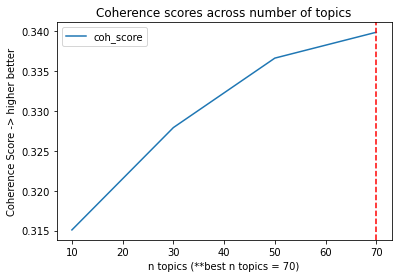

In [14]:
print('Model X Coherence Score evaluation')

# add the scores in a dataframe to plot
df_scores = pd.DataFrame({'coh_score': evaluated_models}, index=n_topics)

# get the max Coherence score
max_score = max(df_scores.coh_score)
# get the index of the max score to draw a vertical line for better readability
index_max_score = df_scores.index[max_score == df_scores.coh_score].tolist()[0]

# plot the scores
ax = df_scores.plot(title= 'Coherence scores across number of topics', xlabel=f'n topics (**best n topics = {index_max_score})', ylabel='Coherence Score -> higher better')
# draw a vertical line on the highest score
ax.axvline(x=index_max_score, color='red', linestyle='--');

## Coherence score gives an indication that 10 topics is optimal but 30 topics just gives a better result finding more similar content.

In [15]:
n_topics

array([10, 30, 50, 70])

In [16]:
best_model = models[3]
best_dictionary = dictionary
best_corpus = corpus
best_matrix_similarity = MatrixSimilarity(best_corpus)

In [17]:
transformed_docs = best_model.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs])

In [18]:
df_tvnz_all_episodes[['tv_index', 'tv_program_id']].reset_index().join(topic_distributions).head()

,index,tv_index,tv_program_id,0,1,2,3,4,5,6,...,60,61,62,63,64,65,66,67,68,69
0,1,1,0,0.002620,0.000386,0.000226,0.002152,0.000769,0.000496,0.002098,...,0.004415,0.004918,0.001397,0.006662,0.000701,0.003377,0.002285,0.005357,0.006515,0.474530
1,3,3,1,0.001348,0.000199,0.000116,0.001107,0.000396,0.000255,0.001080,...,0.002272,0.002531,0.000719,0.003429,0.000361,0.001738,0.001176,0.002757,0.003353,0.001562
2,5,5,2,0.001648,0.000243,0.000142,0.001354,0.000484,0.000312,0.001320,...,0.002778,0.003094,0.000879,0.004192,0.000441,0.002125,0.001438,0.003371,0.004099,0.001910
3,6,6,2,0.001648,0.000243,0.000142,0.001354,0.000484,0.000312,0.001320,...,0.002778,0.003094,0.000879,0.004192,0.000441,0.002125,0.001438,0.003371,0.004099,0.001910
4,8,8,3,0.001935,0.000285,0.000167,0.001590,0.174729,0.000367,0.001550,...,0.003262,0.003633,0.001032,0.353243,0.000518,0.002495,0.001688,0.003958,0.004813,0.002242


In [19]:
# save the topic distribution with probabilities
df_tvnz_all_episodes[['tv_index', 'tv_program_id']].reset_index().join(topic_distributions).iloc[:, 1:].to_csv('../data/recommendations_topics_70.csv', index=False)

## Generating Matrix Similarity and saving it as CSV file

In [41]:
min_sim = 0.5
coo = coo_matrix(best_matrix_similarity)
csr = coo.tocsr()
print(f'{coo.count_nonzero()} similarities to save')

3899754 similarities to save


In [42]:
df_tvnz_all_episodes.head()

,tv_index,tv_program_id,description,doc,lemma
1,1,0,award-winning journalist guyon espiner looks i...,"(award-winning, journalist, guyon, espiner, lo...","[award-winning, journalist, guyon, espiner]"
3,3,1,for two decades international cricket star sac...,"(for, two, decades, international, cricket, st...","[decade, sachin, but, one, thing, eluded, tend..."
5,5,2,part of : using dramatic reconstruction decla...,"(part, , of, :, using, dramatic, reconstructi...","[part, using, cockpit, recorded, thi, untold, ..."
6,6,2,part of : using dramatic reconstruction decla...,"(part, , of, :, using, dramatic, reconstructi...","[part, using, cockpit, recorded, thi, untold, ..."
8,8,3,a social experiment documentary following tee...,"(a, social, experiment, documentary, following...","[teenager, their, birthdays, them, their, parent]"


In [43]:
%%time

# Here we have to save the matrix similarities in csv
xs, ys = coo.nonzero()
to_store = []

docs = df_tvnz_all_episodes.tv_index

for x, y in zip(xs, ys):
    if x == y:
        continue

    sim = float(csr[x, y])
    x_id = str(docs.iloc[x])
    y_id = str(docs.iloc[y])

    to_store.append({
        'tv_show_idx': x_id,
        'tv_show_idy': y_id,
        'score': sim
    })

CPU times: user 1min 10s, sys: 575 ms, total: 1min 10s
Wall time: 1min 11s


In [44]:
to_store[50:60]

[{'tv_show_idx': '3', 'tv_show_idy': '377', 'score': 0.3333333432674408},
 {'tv_show_idx': '3', 'tv_show_idy': '378', 'score': 0.1178511306643486},
 {'tv_show_idx': '3', 'tv_show_idy': '380', 'score': 0.09622504562139511},
 {'tv_show_idx': '3', 'tv_show_idy': '385', 'score': 0.14907120168209076},
 {'tv_show_idx': '3', 'tv_show_idy': '414', 'score': 0.27216553688049316},
 {'tv_show_idx': '3', 'tv_show_idy': '419', 'score': 0.20851440727710724},
 {'tv_show_idx': '3', 'tv_show_idy': '429', 'score': 0.42163702845573425},
 {'tv_show_idx': '3', 'tv_show_idy': '430', 'score': 0.42163702845573425},
 {'tv_show_idx': '3', 'tv_show_idy': '447', 'score': 0.1666666716337204},
 {'tv_show_idx': '3', 'tv_show_idy': '449', 'score': 0.2357022613286972}]

In [45]:
pd.DataFrame(to_store).to_csv('../data/recommendations_content_similarity_topic_30.csv', index=False)

In [46]:
recommendations_content_similarity = pd.read_csv('../data/recommendations_content_similarity_topic_30.csv')
recommendations_content_similarity.head()

,tv_show_idx,tv_show_idy,score
0,1,343,0.267261
1,1,351,0.267261
2,1,374,0.235702
3,1,398,0.267261
4,1,1237,0.267261


Test predicting content based on given keywords

In [24]:
df_tvnz = pd.read_csv('../data/tv_programs_and_episodes.csv')
file_lda_model = '../models/_lda_model_30'
file_topic_distribution = '../data/recommendations_topics_70.csv'

example_keys = ' '.join(['patient', 'quiz'])
example_keys = example_keys.split(' ')

# load pre-trained LDA Mallet model
lda = LdaModel.load(file_lda_model)
# Transform LDA Mallet to LDA model to get the id2word
lda_model = malletmodel2ldamodel(lda)

common_dictionary = lda_model.id2word

unseen_doc = common_dictionary.doc2bow(['food', 'cook', 'baker'])

# get predicted vector
vector = lda_model[unseen_doc]
# get the highest probability topic
best_topic = pd.DataFrame(vector, columns=['topic', 'proba']).sort_values(by='proba', ascending=False).iloc[0, 0]
best_topic

1

In [25]:
# load contents X topic csv
topic_distributions = pd.read_csv(file_topic_distribution)

# get top 10 contents
docs = topic_distributions.iloc[:, [0, 1, best_topic+2]].sort_values(by=f'{best_topic}', ascending=False)[:10]
docs

,tv_index,tv_program_id,1
4122,4834,806,0.881415
4131,4843,806,0.881415
4123,4835,806,0.881415
4124,4836,806,0.881415
4129,4841,806,0.881415
4127,4839,806,0.881415
4126,4838,806,0.871088
4130,4842,806,0.871088
4125,4837,806,0.871088
4128,4840,806,0.871088


In [27]:
# display what the algorithm things by rendering the top 10 words within the topic
words = [word[0] for word in lda.show_topic(best_topic, topn=10)]
print(words)

# get the contents from NPO to display
found = df_tvnz.iloc[docs.iloc[:, 0]]
found

['food', 'cook', 'create', 'dish', 'baker', 'make', 'ingredient', 'learn', 'eat', 'delicious']


,tv_program_id,title,rating,description,is_season,season,episode_id,category,image_url,file_path
4834,806,"Season 9, Episode 29",G,"Abi from Essex will be given five menus, each ...",1,9,1,"['full-seasons', 'reality']","data:image/jpeg;base64,/9j/4AAQSkZJRgABAQEASAB...",NaN
4843,806,"Season 9, Episode 19",G,Nick from Leeds is going to be given five menu...,1,9,10,"['full-seasons', 'reality']",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,NaN
4835,806,"Season 9, Episode 28",G,Ryan from Southampton is going to be given fiv...,1,9,2,"['full-seasons', 'reality']","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN
4836,806,"Season 9, Episode 27",G,Nick from Leeds is going to be given five menu...,1,9,3,"['full-seasons', 'reality']","data:image/jpeg;base64,/9j/4AAQSkZJRgABAQEASAB...",NaN
4841,806,"Season 9, Episode 22",G,"Ella from Cardiff will be given five menus, ea...",1,9,8,"['full-seasons', 'reality']",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,NaN
4839,806,"Season 9, Episode 24",G,Jessica from Manchester will be given five men...,1,9,6,"['full-seasons', 'reality']",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,NaN
4838,806,"Season 9, Episode 25",G,"John from Largs will be given five menus, each...",1,9,5,"['full-seasons', 'reality']",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,NaN
4842,806,"Season 9, Episode 21",G,Daniel from Kent is going to be given five men...,1,9,9,"['full-seasons', 'reality']",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,NaN
4837,806,"Season 9, Episode 26",G,Hayley from Hertfordshire will be given five m...,1,9,4,"['full-seasons', 'reality']",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,NaN
4840,806,"Season 9, Episode 23",G,Olly from Surrey is going to be given five men...,1,9,7,"['full-seasons', 'reality']",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,NaN
